In [1]:
import h2o, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf1e2apxb
  JVM stdout: /tmp/tmpf1e2apxb/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf1e2apxb/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 15 days
H2O_cluster_name:,H2O_from_python_unknownUser_3tqdf1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
# Import the iris dataset into H2O:
iris = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv")
predictors = ["sepal_len", "sepal_wid", "petal_len", "petal_wid"]
iris_df = iris.as_data_frame()
iris_df.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,sepal_len,sepal_wid,petal_len,petal_wid,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 1. Spectral-clustering sklearn

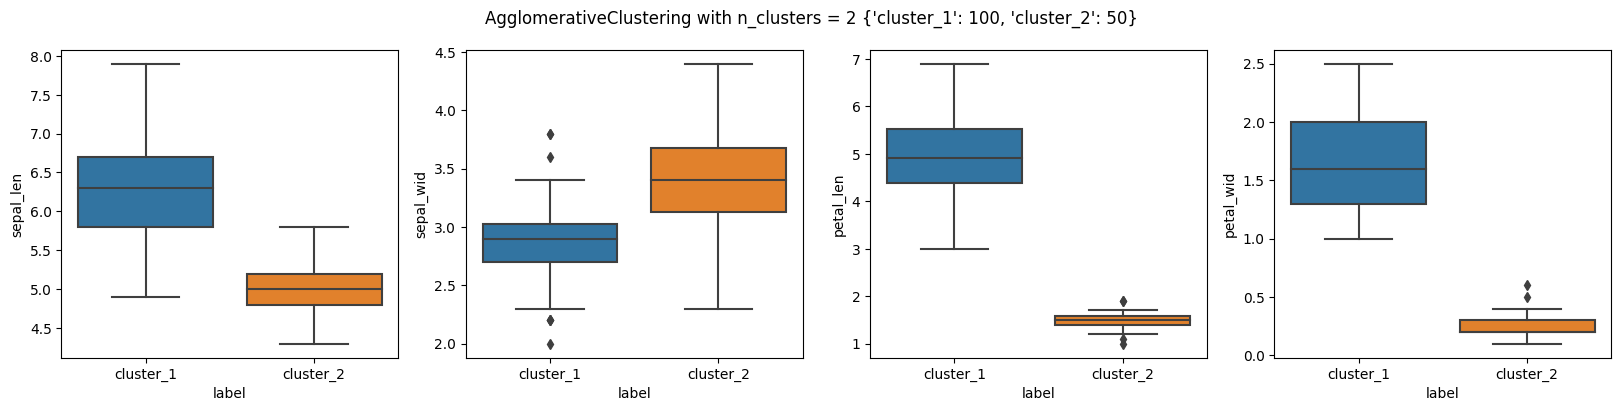

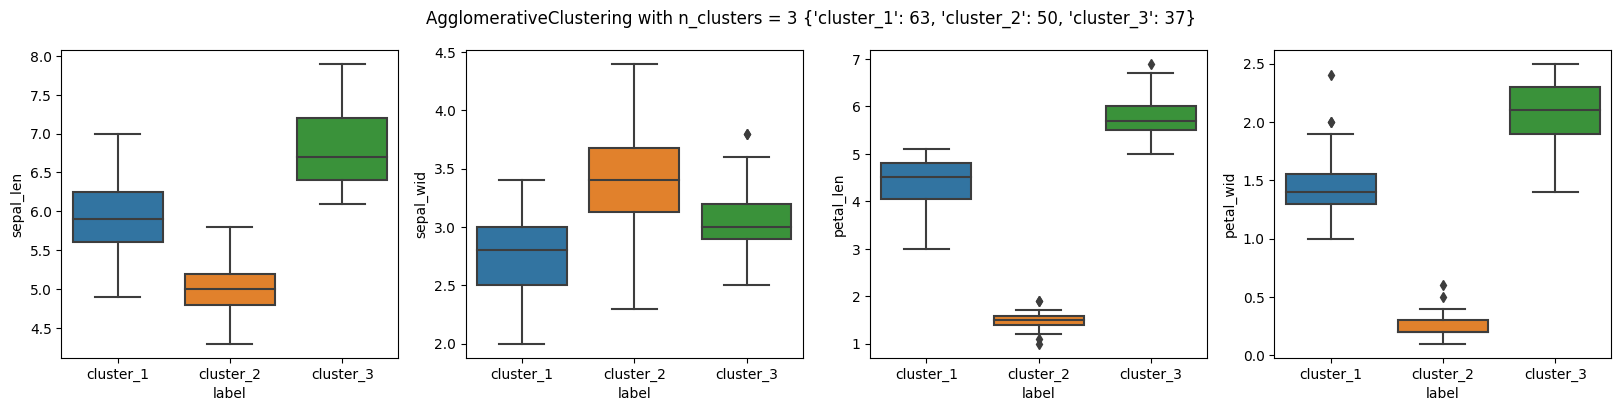

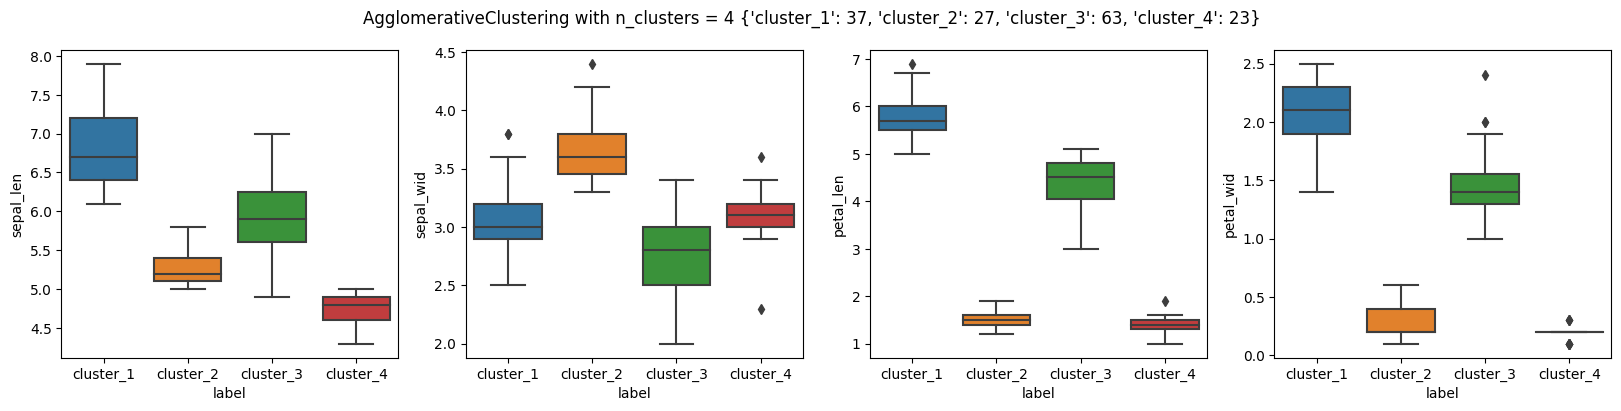

In [3]:
from sklearn.cluster import SpectralClustering

for n_clus in [2,3,4]:
    tempdf = iris_df[predictors].copy()
    model = SpectralClustering(n_clusters=n_clus, affinity='nearest_neighbors', 
                               assign_labels='discretize').fit(tempdf)
    tempdf['label'] = [f"cluster_{cen+1}" for cen in model.labels_]
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    additional_info = tempdf['label'].value_counts().sort_index().to_dict()
    plt.suptitle(f"AgglomerativeClustering with n_clusters = {n_clus} {additional_info}")
    for idx, col in enumerate(predictors):
        sns.boxplot(tempdf, y=col, x='label', 
                    order=[f"cluster_{cen+1}" for cen in range(n_clus)],
                    ax=ax[idx])

Before looking at the comparison

In [4]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 43.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=ca0f0216a727d5799310ffecfbc83b2aa7ed8f6b1c1a01197ecd00f32354358b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


## 2. Comparison
In this example, we only focus on 2 most importance input in `iris` data (`petal_wid`, `petal_len`)

- Since `K-medians` is similar to `K-Means` (replacing `average value` by its `median-value` and only considered if the dataset has too many `outliers`) hence we didn't consider this algorithm in the comparison here.
- Also, here we focus on these following models

| Algorithms | Descriptions |
|-|-|
|KMeans <br>`(sklearn.cluster)`| Find the pair (`centroids-labels`) based on the distance of each data points to `centroid` <br> Must known the `n_clusters`|
|MiniBatchKMeans <br>`(sklearn.cluster)`| `MiniBatchKMeans` is faster, but gives slightly different results (e.g. `total distance from centroids to data-point`)|
|DBSCAN <br>`(sklearn.cluster)`| Stand for **Density-Based Spatial Clustering of Applications with Noise**. It is a **density-based** algorithm that groups together points that are close to each other based on a density criterion. Points that are not part of any cluster are considered **noise**.<br> K-Means tends to work well when the data is well-separated and evenly distributed, while `DBSCAN` is better suited for datasets with irregular shapes or varying densities. <br>`DBSCAN` is that it can find clusters of arbitrary shapes and sizes, unlike K-Means which assumes spherical clusters. `DBSCAN` is also robust to noise and outliers since they are not assigned to any cluster. <br>However, `DBSCAN` can be sensitive to the choice of distance metric and parameters such as the radius and minimum number of points required to form a cluster. <br> * Use `DBSCAN` when the data has irregular shapes or when there is no prior knowledge about the number of clusters. <br> * Use K-Means when the data has spherical shapes and when the number of clusters is known beforehand. <br> If you are unsure which algorithm to use, it is always a good idea to try both algorithms and compare their results.|
|HDBSCAN <br>`(hdbscan)`|
|BIRCH <br>`(sklearn.cluster)`|
|Agglomerative <br>`(sklearn.cluster)`|  Most common type of [hierarchical clustering algorithm](https://phamdinhkhanh.github.io/deepai-book/ch_ml/index_HierarchicalClustering.html) <br> Form of bottom-up clustering, where each data point is assigned to its own cluster. Then those clusters get joined together. <br> At each iteration, similar clusters are merged until all of the data points are part of one big root cluster. <br> Best at finding small clusters.
|Mean-Shift <br>`(sklearn.cluster)`|
|OPTICS <br>`(sklearn.cluster)`|
|Affinity Propagation <br>`(sklearn.cluster)`|
|Spectral Clustering <br>`(sklearn.cluster)`|
|Gaussian mixture model <br>`(sklearn.mixture)`|

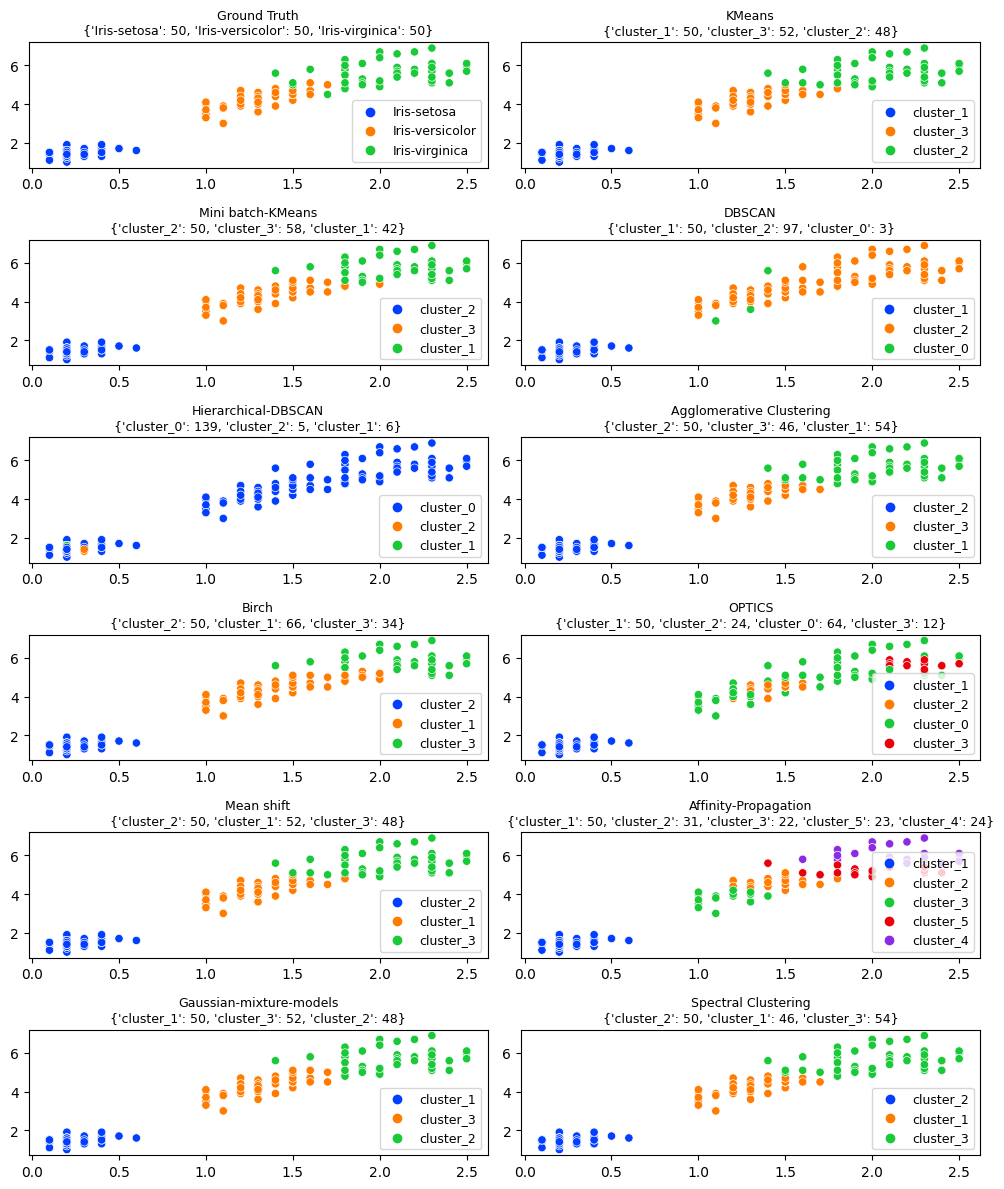

In [5]:
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans, Birch, AgglomerativeClustering, AffinityPropagation, MeanShift, OPTICS
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
from collections import Counter

def fit_and_plot_clusters(X, y, n_clusters=3, seed=111):
    """
        Since the method to obtain the labels is difference (.fit vs .predict) 
        hence I didnt use loop on the algo-names
    """
    # Initialize algorithms then fit to data
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(X)
    dbscan = DBSCAN(eps=0.25, min_samples=3).fit(X)
    hdbscan = HDBSCAN(max_cluster_size=6).fit(X)
    mnbkmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10).fit(X)
    agglom = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X)
    birch = Birch(threshold=0.03, n_clusters=n_clusters).fit(X)
    affine = AffinityPropagation(damping=0.8, max_iter=500).fit(X)
    mshift = MeanShift().fit(X)
    optics = OPTICS(eps=0.25, min_samples=10).fit(X)
    spectral = SpectralClustering(
                                    n_clusters=n_clusters,
                                    random_state=seed,
                                    affinity='nearest_neighbors',
                                    ).fit(X)
    gauss_mixmo = GaussianMixture(n_components=n_clusters).fit(X)
    # for prediction labels
    y_preds = {}
    y_preds['Ground Truth'] = y
    y_preds['KMeans'] = [f"cluster_{k+1}" for k in kmeans.labels_]
    y_preds['Mini batch-KMeans'] = [f"cluster_{k+1}" for k in mnbkmeans.labels_]
    y_preds['DBSCAN'] = [f"cluster_{k+1}" for k in dbscan.labels_]
    y_preds['Hierarchical-DBSCAN'] = [f"cluster_{k+1}" for k in hdbscan.labels_]
    y_preds['Agglomerative Clustering'] = [f"cluster_{k+1}" for k in agglom.labels_]
    y_preds['Birch'] = [f"cluster_{k+1}" for k in birch.predict(X)]
    y_preds['OPTICS'] = [f"cluster_{k+1}" for k in optics.labels_]
    y_preds['Mean shift'] = [f"cluster_{k+1}" for k in mshift.predict(X)]
    y_preds['Affinity-Propagation'] = [f"cluster_{k+1}" for k in affine.predict(X)]
    y_preds['Gaussian-mixture-models'] = [f"cluster_{k+1}" for k in gauss_mixmo.predict(X)]
    y_preds['Spectral Clustering'] = [f"cluster_{k+1}" for k in spectral.labels_]
    
    # Plot predictions vs. ground truth
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 12))
    axes = axes.ravel()
    for i, name in enumerate(y_preds.keys()):
        ax = axes[i]
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_preds[name], ax=ax, legend=True, palette='bright')
        if type(y_preds[name]) == list:
            notes = Counter(y_preds[name])
        else:
            notes = Counter(y_preds[name].to_list())
        ax.set_title(f"{name}\n{dict(notes)}", fontsize=9) 
        ax.legend(loc='lower right', fontsize=9)
    plt.tight_layout()
    plt.show()

fit_and_plot_clusters(iris_df[['petal_wid', 'petal_len']].to_numpy(), iris_df['class'])

In [6]:
import cv2